In [1]:
from library import *

/home/jianming/work/Privatar_prj/custom_scripts/bdct_reconstruction/library.py:45: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(x.shape[1] == 3, "Wrong input, Channel should equals to 3")
/home/jianming/work/Privatar_prj/custom_scripts/bdct_reconstruction/library.py:67: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(x.shape[1] == 3, "Wrong input, Channel should equals to 3")
/home/jianming/work/Privatar_prj/custom_scripts/bdct_reconstruction/library.py:89: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(x.shape[1] == 3, "Wrong input, Channel should equals to 3")
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


camera config file for 6795937 exists, loading...
[['E001_Neutral_Eyes_Open' '000102']
 ['E002_Swallow' '000181']
 ['E017_Jaw_Open_Mouth_Corners_Down_Nose_Wrinkled' '006196']
 ['E018_Raise_Cheeks' '006481']]
['400007', '400042', '400037', '400041', '400010', '400017', '400009', '400061', '400049', '400029', '400051', '400039', '400028', '400013', '400069', '400059', '400023', '400015', '400026', '400018', '400070', '400004', '400064', '400048', '400008', '400050', '400031', '400030', '400060', '400019', '400002', '400016', '400027', '400053', '400063', '400055', '400012', '400067']
checking 0
152


# Dataset Preprocessing + BDCT + Color Conversion + BDCT Extra Preprocessing 
generate post_dataloader_bdct_colorconvert_extrastandard_i.png

In [2]:
for i, data in enumerate(test_loader):
    if i == 10:
        external_data = data
        texture_in = external_data["avg_tex"].cuda()
        bs, ch, h, w = texture_in.shape
        test_inverse_transformed_img = dct_transform_overall(texture_in, bs, ch, h, w)

True


# Dataset Preprocessing + BDCT + Color Conversion + (!Disabled!) No BDCT Extra Preprocessing 
generate post_dataloader_bdct_colorconvert_i.png

In [2]:
for i, data in enumerate(test_loader):
    if i == 10:
        external_data = data
        texture_in = external_data["avg_tex"].cuda()
        bs, ch, h, w = texture_in.shape
        test_inverse_transformed_img = dct_transform_overall_no_extra_standard(texture_in, bs, ch, h, w)

False


# Dataset Preprocessing + BDCT +  (!Disabled!) Color Conversion +  (!Disabled!) No BDCT Extra Preprocessing 
generate post_dataloader_bdct_i.png

In [2]:
for i, data in enumerate(test_loader):
    if i == 10:
        external_data = data
        texture_in = external_data["avg_tex"].cuda()
        bs, ch, h, w = texture_in.shape
        test_inverse_transformed_img = dct_transform_overall_pure_bdct(texture_in, bs, ch, h, w)

True


# Conclusion 1: Pure BDCT already ensures outsourced components to look like random

#### Now let's test the actual BDCT based solutions -> which one of dropping frequency components or duplicated frequency components is better

# Drop high frequency components

In [2]:
for i, data in enumerate(test_loader):
    if i == 10:
        external_data = data
        texture_in = external_data["avg_tex"].cuda()
        bs, ch, h, w = texture_in.shape

        overall_img_drop_high_freq_list = []
        block_size = 4 
        total_block_num = block_size * block_size
        base_freq_cutoff_list = [i for i in range(1, total_block_num+1, 1)]
        for base_freq_cutoff in base_freq_cutoff_list:
            test_inverse_transformed_img = test_img_dct_transform_drop_high_freq_reorder(texture_in, bs, ch, h, w, base_freq_cutoff)
            transforms.functional.to_pil_image(test_inverse_transformed_img.squeeze(0)).save(f'post_dataloader_bdct_drop_high_freq_{base_freq_cutoff}.png')
            overall_img_drop_high_freq_list.append(test_inverse_transformed_img)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True


In [3]:
# Calculate l2 norm between original and each different frequency components
l2_norm_drop_freq_difference_list = []
for i, data in enumerate(test_loader):
    if i == 10:
        external_data = data
        texture_in = external_data["avg_tex"]
        bs, ch, h, w = texture_in.shape
        for img in overall_img_drop_high_freq_list:
            l2_norm_drop_freq_difference_list.append(torch.norm(torch.subtract(img.to("cpu"), texture_in.to("cpu"))))

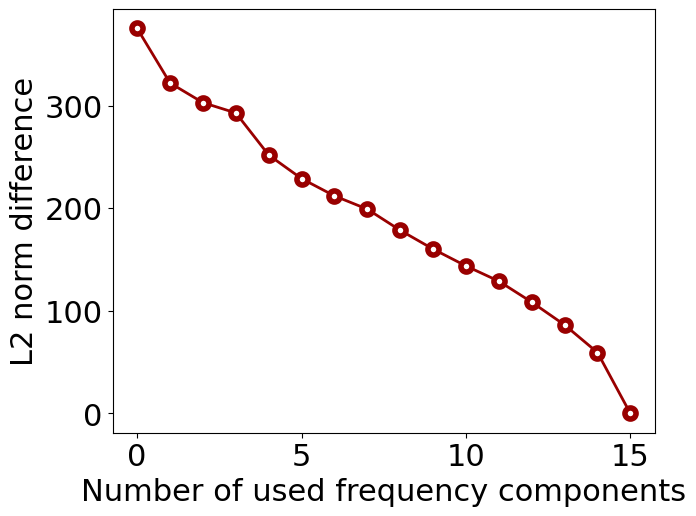

In [10]:
import matplotlib.pyplot as plt

prior_sr =  1/66
fig = plt.figure(figsize=[7,5.5])
ax = plt.subplot(111)
x = [i for i in range(len(l2_norm_drop_freq_difference_list))]
# l2_norm_noise = l2_norm_noise[::-1]
# prior_successful_rate_list = prior_successful_rate_list[::-1]
plt.plot(x, l2_norm_drop_freq_difference_list, color="#990000", marker=".", markerfacecolor="#ffffff", markersize=16, linewidth=2, markeredgewidth=4)

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.ylabel("L2 norm difference", fontsize=BIGGER_SIZE)
plt.xlabel("Number of used frequency components", fontsize=BIGGER_SIZE)
# plt.xticks([i for i in range(int(max(tflop_list)+1))], [str(i) for i in range(int(max(tflop_list)+1))], fontsize=MEDIUM_SIZE)
# plt.title("Scores by Teams in 4 Rounds")

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize

plt.savefig('l2norm_under_various_freq_comp_dataloader.pdf', bbox_inches="tight", transparent=True) 

plt.show()

# Duplicate low frequency components

In [15]:
overall_img_duplicate_freq_list = []
for i, data in enumerate(test_loader):
    if i == 10:
        external_data = data
        texture_in = external_data["avg_tex"].cpu()
        bs, ch, h, w = texture_in.shape

        base_freq_cutoff_list = [i for i in range(1,total_block_num+1,1)]
        for base_freq_cutoff in base_freq_cutoff_list:
            test_inverse_transformed_img = test_img_dct_transform_duplicate_freq_reorder(texture_in, bs, ch, h, w, base_freq_cutoff)
            transforms.functional.to_pil_image(test_inverse_transformed_img.squeeze(0)).save(f'post_dataloader_bdct_duplicate_freq_{base_freq_cutoff}.png')
            overall_img_duplicate_freq_list.append(test_inverse_transformed_img)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [16]:
# Calculate l2 norm between original and each different frequency components
l2_norm_duplicate_freq_difference_list = []
for i, data in enumerate(test_loader):
    if i == 10:
        external_data = data
        texture_in = external_data["avg_tex"].cpu()
        bs, ch, h, w = texture_in.shape
        for img in overall_img_duplicate_freq_list:
            l2_norm_duplicate_freq_difference_list.append(torch.norm(torch.subtract(img.to("cpu"), texture_in.to("cpu"))))

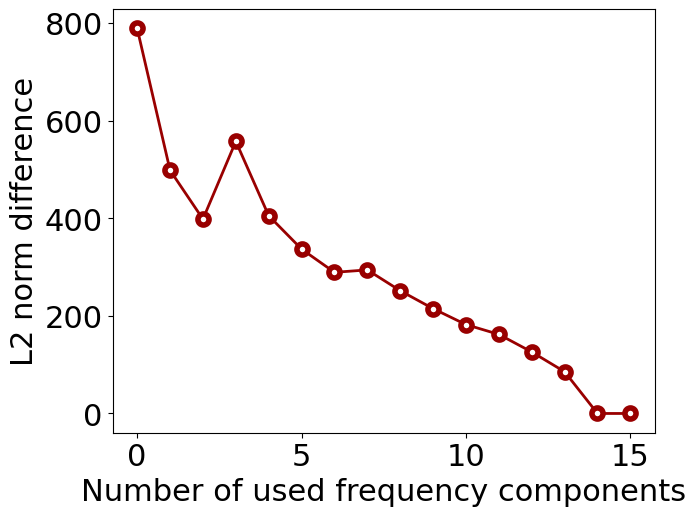

In [17]:
import matplotlib.pyplot as plt

prior_sr =  1/66
fig = plt.figure(figsize=[7,5.5])
ax = plt.subplot(111)
x = [i for i in range(len(l2_norm_duplicate_freq_difference_list))]
# l2_norm_noise = l2_norm_noise[::-1]
# prior_successful_rate_list = prior_successful_rate_list[::-1]
plt.plot(x, l2_norm_duplicate_freq_difference_list, color="#990000", marker=".", markerfacecolor="#ffffff", markersize=16, linewidth=2, markeredgewidth=4)

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.ylabel("L2 norm difference", fontsize=BIGGER_SIZE)
plt.xlabel("Number of used frequency components", fontsize=BIGGER_SIZE)
# plt.xticks([i for i in range(int(max(tflop_list)+1))], [str(i) for i in range(int(max(tflop_list)+1))], fontsize=MEDIUM_SIZE)
# plt.title("Scores by Teams in 4 Rounds")

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize

plt.savefig('l2norm_duplicated_freq_comp_dataloader.pdf', bbox_inches="tight", transparent=True) 

plt.show()

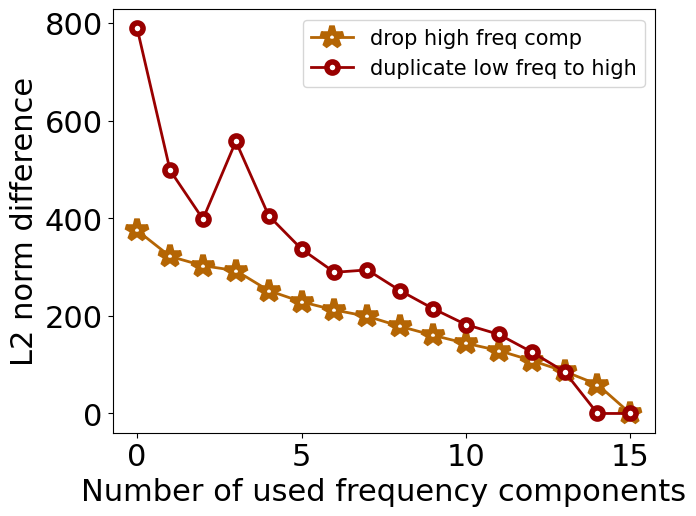

In [18]:
import matplotlib.pyplot as plt

prior_sr =  1/66
fig = plt.figure(figsize=[7,5.5])
ax = plt.subplot(111)
x = [i for i in range(len(l2_norm_duplicate_freq_difference_list))]
# l2_norm_noise = l2_norm_noise[::-1]
# prior_successful_rate_list = prior_successful_rate_list[::-1]
plt_handler = []
plt_handler.append(plt.plot(x, l2_norm_drop_freq_difference_list, marker="*", markerfacecolor="#ffffff", color="#B46504", markersize=16, linewidth=2, markeredgewidth=4)[0])
plt_handler.append(plt.plot(x, l2_norm_duplicate_freq_difference_list, color="#990000", marker=".", markerfacecolor="#ffffff", markersize=16, linewidth=2, markeredgewidth=4)[0])

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.ylabel("L2 norm difference", fontsize=BIGGER_SIZE)
plt.xlabel("Number of used frequency components", fontsize=BIGGER_SIZE)
# plt.xticks([i for i in range(int(max(tflop_list)+1))], [str(i) for i in range(int(max(tflop_list)+1))], fontsize=MEDIUM_SIZE)
# plt.title("Scores by Teams in 4 Rounds")

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.legend(plt_handler, [r"drop high freq comp", r"duplicate low freq to high"], loc='best', ncol=1, fontsize=15)

plt.savefig('l2norm_undervarious_freq_drop_duplicate_comp_dataloader.pdf', bbox_inches="tight", transparent=True) 

plt.show()

# Drop low frequency components

In [19]:
overall_img_drop_low_freq_list = []
for i, data in enumerate(test_loader):
    if i == 10:
        external_data = data
        texture_in = external_data["avg_tex"].cpu()
        bs, ch, h, w = texture_in.shape

        block_size = 4 
        total_block_num = block_size * block_size
        base_freq_cutoff_list = [i for i in range(1, total_block_num+1, 1)]
        for base_freq_cutoff in base_freq_cutoff_list:
            test_inverse_transformed_img = test_img_dct_transform_drop_low_freq_reorder(texture_in, bs, ch, h, w, base_freq_cutoff)
            transforms.functional.to_pil_image(test_inverse_transformed_img.squeeze(0)).save(f'post_dataloader_bdct_drop_low_freq_{base_freq_cutoff}.png')
            overall_img_drop_low_freq_list.append(test_inverse_transformed_img)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [20]:
# Calculate l2 norm between original and each different frequency components
l2_norm_drop_freq_difference_list = []
for i, data in enumerate(test_loader):
    if i == 10:
        external_data = data
        texture_in = external_data["avg_tex"].cpu()
        bs, ch, h, w = texture_in.shape

        for img in overall_img_drop_low_freq_list:
            l2_norm_drop_freq_difference_list.append(torch.norm(torch.subtract(img, texture_in)))

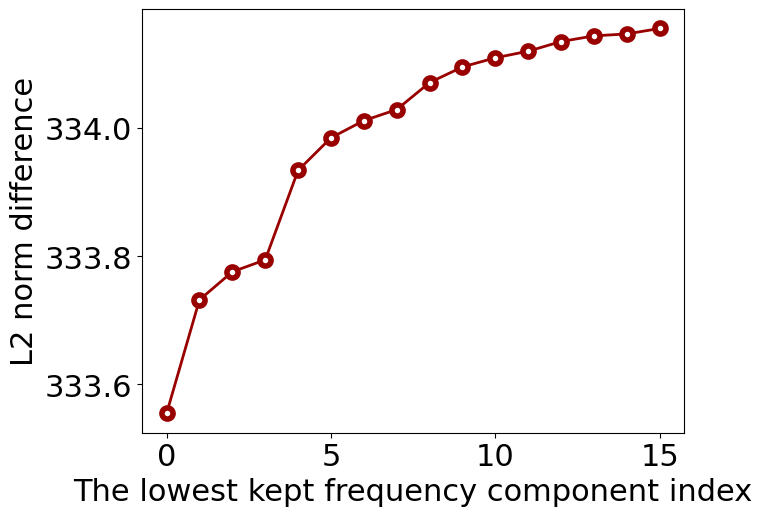

In [ ]:
import matplotlib.pyplot as plt

prior_sr =  1/66
fig = plt.figure(figsize=[7,5.5])
ax = plt.subplot(111)
x = [i for i in range(len(l2_norm_drop_freq_difference_list))]
# l2_norm_noise = l2_norm_noise[::-1]
# prior_successful_rate_list = prior_successful_rate_list[::-1]
plt.plot(x, l2_norm_drop_freq_difference_list, color="#990000", marker=".", markerfacecolor="#ffffff", markersize=16, linewidth=2, markeredgewidth=4)

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.ylabel("L2 norm difference", fontsize=BIGGER_SIZE)
plt.xlabel("The lowest kept frequency component index", fontsize=BIGGER_SIZE)
# plt.xticks([i for i in range(int(max(tflop_list)+1))], [str(i) for i in range(int(max(tflop_list)+1))], fontsize=MEDIUM_SIZE)
# plt.title("Scores by Teams in 4 Rounds")

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize

plt.savefig('l2norm_under_various_freq_comp_drop_lower.pdf', bbox_inches="tight", transparent=True) 

plt.show()